# Zonal Statistics


# Introduction to code
1. calculate zonal statistics for (indirect nutrient load/stream)WatershedPourPoints_LH.shp
2. Calculate Zonal statistics for (direct nutrient flux/coastal wetland corresponding watershed)wetland_connected_avg_inundation_NAD1983_Watershed
3. Subtract the values of flux that have overlap 

# Zonal Statistics for Coastal Watersheds

This notebook calculates zonal statistics/Nutrient flux for the coastal watersheds in the Great Lakes region.


## Objectives:
1. **Integrate Coastal Watershed Data**:
   - Utilize the delineated coastal watersheds as zones for statistical analysis.

2. **Compute Spatial Metrics**:
   - Perform calculations, such as mean, sum, and area-weighted averages, for variables like:
     - Land use types.
     - Vegetation cover.
     - Hydrological properties.

3. **Export Results for Further Analysis**:
   - Aggregate and save the results in a structured format to facilitate downstream analysis and visualization.

## Workflow:
1. **Data Loading**:
   - Import relevant spatial datasets, including raster and vector files.
   - Integrate delineated coastal watershed data from previous analyses.

2. **Zonal Statistics Calculation**:
   - Apply zonal statistics tools to compute desired metrics over each watershed zone.

3. **Result Validation and Export**:
   - Validate calculated statistics.
   - Export the results as tables or geospatial files for further use.

---

This notebook is a critical step in quantifying spatial characteristics within the Great Lakes coastal watersheds, supporting environmental management and decision-making.


# Required Imports

In [1]:
### Reqiured Imports###
import pandas, os
import arcpy
import pandas as pd
import geopandas as gpd
import numpy as np
from arcpy.sa import *
import matplotlib.pyplot as plt

# Inputs

In [2]:

# Define the base paths
base_path = r'D:\Users\abolmaal\Arcgis\NASAOceanProject'
nutrient_flux_path = r'D:\Users\abolmaal\Arcgis\NASAOceanProject\Luwen_Nutrient'
coastal_watersheds_path = r'D:\Users\abolmaal\Arcgis\NASAOceanProject\GIS_layer\CoastalWatersheds\Erase_Lake'
#TotalLOad = r'D:\Users\abolmaal\Arcgis\NASAOceanProject\ZonalStats\CoastalWatershed_total_N_P_avg._directandIndirect.csv'
# Define the input paths
inDB = os.path.join(base_path, 'GIS_layer', 'Streamwatershed')


# Nutrient flux rasters
inBYRaster_TN = os.path.join(nutrient_flux_path, 'TN_Annual_delTotal_header_kgcellday.tif')
inBYRaster_TP = os.path.join(nutrient_flux_path, 'TP_Annual_delTotal_header_kgcellday.tif')

# Define the input feature classes
inPourpoint = 'WatershedPourPoints_NAD1983'

inWatershed = os.path.join(inDB, 'PointWatershed_LH_NAD1983_NASA_Invasive.shp')

# Define coastal watersheds
inCW = os.path.join(coastal_watersheds_path, 'Erase_drainage')
inCoastalWatershed_avg =os.path.join(coastal_watersheds_path, 'CoastalWatershed_avg_erase_lakedrain_LakeHuron.shp')
inCoastalWatershed_low = os.path.join(coastal_watersheds_path,'CoastalWatershed_low_erase_lakedrain_LakeHuron.shp')
inCoastalWatershed_high =os.path.join(coastal_watersheds_path,'CoastalWatershed_high_erase_lakedrain_LakeHuron.shp')
inCoastalWatershed_surge = os.path.join(coastal_watersheds_path,'CoastalWatershed_surge_erase_lakedrain_LakeHuron.shp')


# Define the path to coastal wetlands
# this the path of coastal wetlands shapefiles that we remove the riperian buffer which is removing the 50m buffer overlap with stream watersheds
incoastalwetland = r"D:\Users\abolmaal\Arcgis\NASAOceanProject\GIS_layer\CoastalWatersheds\Erase_Riperian" 
# Read shapefiles into GeoDataFrames
inCoastalWetland_avg = gpd.read_file(os.path.join(incoastalwetland, 'Wetland_connected_avg_erasebuff_50.shp'))
inCoastalWetland_low = gpd.read_file(os.path.join(incoastalwetland, 'Wetland_connected_low_erasebuff_50.shp'))
inCoastalWetland_high = gpd.read_file(os.path.join(incoastalwetland, 'Wetland_connected_high_erasebuff_50.shp'))
inCoastalWetland_surge = gpd.read_file(os.path.join(incoastalwetland, 'Wetland_connected_surge_erasebuff_50.shp'))

# Output coastal feature
outTable = 'direct_coastal_N_P_wetland_loads'
outFeature = 'wetland_connected_avg_inundation_Albers'

# Environment settings
arcpy.env.overwriteOutput = True
arcpy.env.workspace = inDB


# path to Lake Huron shapefile

Lake_Huron = r"D:\Users\abolmaal\code\boundry\hydro_p_LakeHuron\hydro_p_LakeHuron.shp"


In [4]:
ds= inCoastalWetland_avg
ds.head()

,ID,GRIDCODE,Wetland,Shape_Area,Shape_Len,gridcode_1,BUFF_DIST,CW_Id,Coastal_ID,geometry
0,4592,15,Emergent Wetland,1.226935e+05,2132.422988,0,2000.0,1,1,"MULTIPOLYGON (((1025414.005 999595.395, 102540..."
1,5730,15,Emergent Wetland,1.037015e+06,11976.973780,0,2000.0,2,2,"POLYGON ((1025406.38 999482.295, 1025431.303 9..."
2,5833,15,Emergent Wetland,8.403687e+03,410.115930,0,2000.0,3,3,"POLYGON ((1025693.126 998329.404, 1025673.597 ..."
3,6245,15,Emergent Wetland,1.899233e+05,3201.142242,0,2000.0,4,4,"MULTIPOLYGON (((1025654.745 997988.602, 102565..."
4,6344,15,Emergent Wetland,1.680737e+03,163.987438,0,2000.0,5,5,"POLYGON ((1025693.991 997728.001, 1025681.53 9..."


In [3]:
# remove column [FOD_Wetlan,Id_1,FID_lh_sho,Id_12,ORIG_FID] from the inCoastalWetland_avg, inCoastalWetland_low, inCoastalWetland_high, inCoastalWetland_surge dataframes
inCoastalWetland_avg = inCoastalWetland_avg.drop(columns=['FID_Wetlan','Id_1','FID_lh_sho','Id_12','ORIG_FID'])
inCoastalWetland_low = inCoastalWetland_low.drop(columns=['FID_Wetlan','Id_1','FID_lh_sho','Id_12','ORIG_FID'])
inCoastalWetland_high = inCoastalWetland_high.drop(columns=['FID_Wetlan','Id_1','FID_lh_sho','Id_12','ORIG_FID'])
inCoastalWetland_surge = inCoastalWetland_surge.drop(columns=['FID_Wetlan','Id_1','FID_lh_sho','Id_12','ORIG_FID'])

# Outputs

In [5]:
outBYRaster_TN =  os.path.join(nutrient_flux_path, 'TN_Annual_kgcellday_header_kgcellday_converted.tif')
outByRaster_TP =  os.path.join(nutrient_flux_path, 'TP_Annual_delTotal_header_kgcellday_converted.tif')

# out path
outDb = os.path.join(base_path, 'ZonalStats')

# Fields to calculate / Direct delivery to Watersheds
StreamDirectTN = 'StreamDirectTN_kgday'
StreamDirectTN_converted = 'StreamDirectTN_grm2yr'
StreamDirectTP = 'StreamDirectTP_kgday'
StreamDirectTN_converted = 'StreamDirectTN_grm2yr'
# out name for the zonal stats Stream watersheds
outStreamWatershed = os.path.join(outDb, 'DirectTNTP_StreamWatresheds.csv')



# Direct delivery to Coastal Watersheds
CoastalDirectTN_avg = 'CoastalWatershedDirectTN_avg_kgday'
CoastalDirectTN_avg_convert = 'CoastalWatershedDirectTN_avg_grm2yr'
CoastalDirectTP_avg = 'CoastalWatershedDirectTP_avg_kgday'
CoastalDirectTP_avg_convert = 'CoastalWatershedDirectTP_avg_grm2yr'


CoastalDirectTN_low = 'CoastalWatershedDirectTN_low_kgday'
CoastalDirectTN_low_convert = 'CoastalWatershedDirectTN_low_grm2yr'
CoastalDirectTP_low = 'CoastalWatershedDirectTP_low_kgday'
CoastalDirectTP_low_convert = 'CoastalWatershedDirectTP_low_grm2yr'


CoastalDirectTN_high = 'CoastalWatershedDirectTN_high_kgday'
CoastalDirectTN_high_convert = 'CoastalWatershedDirectTN_high_grm2yr'
CoastalDirectTP_high_convert = 'CoastalWatershedDirectTP_high_grm2yr'
CoastalDirectTP_high = 'CoastalWatershedDirectTP_high_kgday'

CoastalDirectTN_surge = 'CoastalWatershedDirectTN_surge_kgday'
CoastalDirectTN_surge_convert = 'CoastalWatershedDirectTN_surge_grm2yr'
CoastalDirectTP_surge = 'CoastalWatershedDirectTP_surge_kgday'
CoastalDirectTP_surge_convert = 'CoastalWatershedDirectTP_surge_grm2yr'

# out names to save the zonal stats for the coastal watersheds
outCoastalWatershed_avg = os.path.join(outDb, 'DirectTNTP_CoastalWatershed_avg.csv')
outCoastalWatershed_low = os.path.join(outDb, 'DirectTNTP_CoastalWatershed_low.csv')
outCoastalWatershed_high = os.path.join(outDb, 'DirectTNTP_CoastalWatershed_high.csv')
outCoastalWatershed_surge = os.path.join(outDb, 'DirectTNTP_CoastalWatershed_surge.csv')

outFig = os.path.join(base_path, 'figures')


# Parameters

In [6]:
# define the watershed number, this number is the same as the FID number and it is used to number the watersheds and we will use this for particle tracking
#watershed_num = 'StWater_id'
# define the watershed number
watershed_num = "Group_id"
# define the coastal wetland number which is same as FID number+1
Coastal_num = "CW_Id"
Area = 'CW_Area'
Coastal_ID = "Coastal_ID"

In [7]:
# Shared columns
lat_col = "start_lat"
lon_col = "start_lon"
id_col = "CW_Id"
drop_cols = ['coastal_watershed_area','geometry']  # modify if others exist

In [34]:
# i check the names in the coastal wetlands and some need correcting
# rename the column Cw_Id to CW_Id in all coastal wetlands low dataframes
inCoastalWetland_low.rename(columns={'Cw_Id': 'CW_Id'}, inplace=True)
# rename the column Cw_Area to CW_Area in all coastal wetlands low dataframes
inCoastalWetland_low.rename(columns={'Cw_Area': 'CW_Area'}, inplace=True)

# Main Functions

## Function to convert units from kg/day to gram/m2/year

In [8]:
def convert_kgday_to_grm2yr(df, kgday_col, area_col, new_col):
    """
    Converts values from kg/day to grams/m²/year.

    Parameters:
    - df: DataFrame containing the data
    - kgday_col: Column with kg/day values
    - area_col: Column with area in m²
    - new_col: Name of the output column (g/m²/year)
    """
    df[new_col] = ((df[kgday_col] * 1000 * 365) / df[area_col])


## Direct Nutrient Load to Stream Watersheds

####  Bring in Streamwatershed into a pandas dataframe and get the specific columns


In [9]:
# Bring in Stream watersheds into a pandas dataframe and get the specific columns

dfWatershed = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inDB,inWatershed), [watershed_num, 'gridcode','Shape_Area']))

### Estimate Zonal statistics for StreamWatreshed
Bring in the nutrient flux rasters into a pandas dataframe and estimate the total nutrient load in the Streamwatershed

In [11]:
# 1- calculate the zonal statistics with arcpy for inWatershed using inBYRaster
inZonalTN_watershed = arcpy.sa.ZonalStatisticsAsTable(inWatershed, watershed_num, inBYRaster_TN, 'SUM' ,'DATA')

# # bring in inWatershed and inZonalTN_watershed as pandas dataframes
dfZonalTN_watershed = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_watershed,
                                                                  [watershed_num, 'AREA','SUM']))
#rename the SUM field to fieldDirectTN
dfZonalTN_watershed.rename(columns={'SUM': StreamDirectTN}, inplace=True)
dfZonalTN_watershed

,Group_id,AREA,StreamDirectTN_kgday
0,0,2.590560e+07,13.480809
1,1,6.922080e+07,51.878556
2,2,1.704240e+08,87.793043
3,3,9.429120e+07,54.996792
4,4,3.777120e+07,27.250568
...,...,...,...
140,170,1.959840e+07,63.984811
141,171,1.440000e+04,0.013980
142,173,1.376640e+07,23.636322
143,174,7.776000e+06,14.078233


In [12]:
inZonalTP_watershed = arcpy.sa.ZonalStatisticsAsTable(inWatershed,watershed_num, inBYRaster_TP, 'SUM' ,'DATA')
dfZonalTP_watershed = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_watershed, 
                                                                   [watershed_num, 'AREA','SUM']))
# rename the SUM field to fieldDirectTP
dfZonalTP_watershed.rename(columns={'SUM': StreamDirectTP}, inplace=True)

dfZonalTP_watershed

,Group_id,AREA,StreamDirectTP_kgday
0,0,2.590560e+07,0.974675
1,1,6.922080e+07,2.000936
2,2,1.704240e+08,4.179389
3,3,9.429120e+07,3.598198
4,4,3.777120e+07,1.326998
...,...,...,...
140,170,1.959840e+07,4.299652
141,171,1.440000e+04,0.000563
142,173,1.376640e+07,4.034916
143,174,7.776000e+06,2.496025


###  Merge Streamwatershed for TN and TP

In [13]:
# merge dfWateshed with dfZonalTN_watershed where dfWateshed['Group_id'] = dfZonalTN_watershed['Group_id']
dfWatershed = dfWatershed.merge(dfZonalTP_watershed, left_on= watershed_num, right_on= watershed_num, how='inner')
# merge dfWateshed with dfZonalTN_watershed where dfWateshed['Group_id'] = dfZonalTN_watershed['Group_id']
dfWatershed = dfWatershed.merge(dfZonalTN_watershed, left_on=watershed_num, right_on=watershed_num, how='inner')
dfWatershed.describe()

,Group_id,gridcode,Shape_Area,AREA_x,StreamDirectTP_kgday,AREA_y,StreamDirectTN_kgday
count,145.000000,145.000000,1.450000e+02,1.450000e+02,145.000000,1.450000e+02,145.000000
mean,86.206897,22606.744828,2.826691e+08,2.826284e+08,15.842889,2.826284e+08,473.963111
std,48.730964,3903.146287,1.387888e+09,1.387966e+09,87.146100,1.387966e+09,2470.892463
min,0.000000,1010.000000,9.000000e+02,1.440000e+04,0.000317,1.440000e+04,0.005884
25%,45.000000,22077.000000,4.967295e+06,4.809600e+06,0.304878,4.809600e+06,11.949760
50%,85.000000,22221.000000,1.396735e+07,1.376640e+07,0.974675,1.376640e+07,39.954672
75%,125.000000,22630.000000,6.915027e+07,6.922080e+07,3.828006,6.922080e+07,116.632577
max,176.000000,48120.000000,1.496975e+10,1.497086e+10,996.783451,1.497086e+10,28752.263320


In [14]:
# remove the unnecessary columns from dfWatershed
dfWatershed.drop(columns=['AREA_x','AREA_y','gridcode'], inplace=True)


### Save stream watershed Nutrient load

In [15]:
# Save the dfWateshed to a csv file in the inDB directory with the name of Watresheds_total_N_P.csv
dfWatershed.to_csv(os.path.join(outDb, outStreamWatershed), index=False)

In [16]:
# delete the extra columns then save them and rename them that make sense
# convert dfWatershed to a pandas dataframe
dfWatershed_pd = pd.DataFrame(dfWatershed)
# save dfWatershed_pd to a shape file in outDb with name outTable + '.shp'
dfWatershed_pd.to_csv(os.path.join(outDb, outTable + '.shp'))

## 2- Zonal Statistics for Coastal Wetlands' watershed for Different Innundation

Calculate the zonal statistics with arcpy for inCoastawateshed using inBYRaster_TN, and inBYRaster_TP


In [29]:
#bring in the coastalwatreshed

dfCoastalWatershed_avg = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inCW,inCoastalWatershed_avg),
                                                                  [Coastal_num, Coastal_ID,'CW_Area','cent_lat','cent_lon']))

dfCoastalWatershed_low = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inCW,inCoastalWatershed_low),
                                                                  [Coastal_num, Coastal_ID,'CW_Area','cent_lat','cent_lon']))

dfCoastalWatershed_high = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inCW,inCoastalWatershed_high),
                                                                  [Coastal_num, Coastal_ID,'CW_Area', 'cent_lat','cent_lon']))

dfCoastalWatershed_surge = pandas.DataFrame(arcpy.da.TableToNumPyArray(os.path.join(inCW,inCoastalWatershed_surge),
                                                                  [Coastal_num, Coastal_ID,'CW_Area', 'cent_lat','cent_lon']))

#### Average Innundation

In [ ]:
# 1- Calculate the zonal statistics with arcpy for inCoastalWatershed High inundation using inBYRaster_TN and inBYRaster_TP
inZonalTN_coastal_avg = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_avg, Coastal_num, inBYRaster_TN, 'SUM' ,'DATA')
inZonalTP_coastal_avg = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_avg, Coastal_num, inBYRaster_TP, 'SUM' ,'DATA')

# # bring in inCoastalWatershed and inZonalTN_coastal as pandas dataframes
dfZonalTN_coastal_avg = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_avg,
                                                                  [Coastal_num, 'AREA','SUM']))

dfZonalTP_coastal_avg = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_avg,
                                                                  [Coastal_num, 'AREA','SUM']))
# add a field to dfZonal_TN_coastal_avg called fieldCoastalTN_high which is equal to SUM column divided by Shape_Area
dfZonalTN_coastal_avg.rename(columns={'SUM': CoastalDirectTN_avg}, inplace=True)

# add a field to dfZonal_TP_coastal_avg called fieldCoastalTP_avg which is equal to SUM column divided by Shape_Area
dfZonalTP_coastal_avg.rename(columns={'SUM': CoastalDirectTP_avg}, inplace=True)
# merge dfZonalTN_coastal_avg and dfZonalTP_coastal_avg with dfCoastalWatershed_avg
dfCoastalWatershed_avg = dfCoastalWatershed_avg.merge(dfZonalTN_coastal_avg, left_on=Coastal_num, right_on=Coastal_num, how='inner')
dfCoastalWatershed_avg = dfCoastalWatershed_avg.merge(dfZonalTP_coastal_avg, left_on=Coastal_num, right_on=Coastal_num, how='inner')
dfCoastalWatershed_avg.drop(columns=['AREA_x','AREA_y'], inplace=True)


### High inundation 


In [37]:
# 1- Calculate the zonal statistics with arcpy for inCoastalWatershed High inundation using inBYRaster_TN and inBYRaster_TP
inZonalTN_coastal_high = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_high, Coastal_num, inBYRaster_TN, 'SUM' ,'DATA')
inZonalTP_coastal_high = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_high, Coastal_num, inBYRaster_TP, 'SUM' ,'DATA')

# # bring in inCoastalWatershed and inZonalTN_coastal as pandas dataframes
dfZonalTN_coastal_high = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_high,
                                                                  [Coastal_num, 'AREA','SUM']))

dfZonalTP_coastal_high = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_high,
                                                                  [Coastal_num, 'AREA','SUM']))
# add a field to dfZonal_TN_coastal_avg called fieldCoastalTN_high which is equal to SUM column divided by Shape_Area
dfZonalTN_coastal_high.rename(columns={'SUM': CoastalDirectTN_high}, inplace=True)


# add a field to dfZonal_TP_coastal_avg called fieldCoastalTP_avg which is equal to SUM column divided by Shape_Area
dfZonalTP_coastal_high.rename(columns={'SUM': CoastalDirectTP_high}, inplace=True)
# merge dfZonalTN_coastal_avg and dfZonalTP_coastal_avg with dfCoastalWatershed_high
dfCoastalWatershed_high = dfCoastalWatershed_high.merge(dfZonalTN_coastal_high, left_on=Coastal_num, right_on=Coastal_num, how='inner')
dfCoastalWatershed_high = dfCoastalWatershed_high.merge(dfZonalTP_coastal_high, left_on=Coastal_num, right_on=Coastal_num, how='inner')
dfCoastalWatershed_high.drop(columns=['AREA_x','AREA_y'], inplace=True)

### Low inundation


In [40]:
# 1- Calculate the zonal statistics with arcpy for inCoastalWatershed low inundation using inBYRaster_TN and inBYRaster_TP
inZonalTN_coastal_low = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_low, Coastal_num, inBYRaster_TN, 'SUM' ,'DATA')
inZonalTP_coastal_low = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_low, Coastal_num, inBYRaster_TP, 'SUM' ,'DATA')

# # bring in inCoastalWatershed and inZonalTN_coastal as pandas dataframes
dfZonalTN_coastal_low = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_low,
                                                                  [Coastal_num, 'AREA','SUM']))

dfZonalTP_coastal_low = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_low,
                                                                  [Coastal_num, 'AREA','SUM']))
# add a field to dfZonal_TN_coastal_avg called fieldCoastalTN_avg which is equal to SUM column divided by Shape_Area
dfZonalTN_coastal_low.rename(columns={'SUM': CoastalDirectTN_low}, inplace=True)


# add a field to dfZonal_TP_coastal_avg called fieldCoastalTP_avg which is equal to SUM column divided by Shape_Area
dfZonalTP_coastal_low.rename(columns={'SUM': CoastalDirectTP_low}, inplace=True)
# merge dfZonalTN_coastal_avg and dfZonalTP_coastal_avg with dfCoastalWatershed_avg
dfCoastalWatershed_low = dfCoastalWatershed_low.merge(dfZonalTN_coastal_low, left_on=Coastal_num, right_on=Coastal_num, how='inner')
dfCoastalWatershed_low = dfCoastalWatershed_low.merge(dfZonalTP_coastal_low, left_on=Coastal_num, right_on=Coastal_num, how='inner')
dfCoastalWatershed_low.drop(columns=['AREA_x','AREA_y'], inplace=True)

### Surge inundation


In [43]:
# 1- Calculate the zonal statistics with arcpy for inCoastalWatershed average inundation using inBYRaster_TN and inBYRaster_TP
inZonalTN_coastal_surge = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_surge, Coastal_num, inBYRaster_TN, 'SUM' ,'DATA')
inZonalTP_coastal_surge = arcpy.sa.ZonalStatisticsAsTable(inCoastalWatershed_surge, Coastal_num, inBYRaster_TP, 'SUM' ,'DATA')

# # bring in inCoastalWatershed and inZonalTN_coastal as pandas dataframes
dfZonalTN_coastal_surge = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTN_coastal_surge,
                                                                  [Coastal_num, 'AREA','SUM']))

dfZonalTP_coastal_surge = pandas.DataFrame(arcpy.da.TableToNumPyArray(inZonalTP_coastal_surge,
                                                                  [Coastal_num, 'AREA','SUM']))
# add a field to dfZonal_TN_coastal_avg called fieldCoastalTN_avg which is eual to SUM column divided by Shape_Area
dfZonalTN_coastal_surge.rename(columns={'SUM': CoastalDirectTN_surge}, inplace=True)


# add a field to dfZonal_TP_coastal_avg called fieldCoastalTP_avg which is eual to SUM column divided by Shape_Area
dfZonalTP_coastal_surge.rename(columns={'SUM': CoastalDirectTP_surge}, inplace=True)
# merge dfZonalTN_coastal_avg and dfZonalTP_coastal_avg with dfCoastalWatershed_surge
dfCoastalWatershed_surge = dfCoastalWatershed_surge.merge(dfZonalTN_coastal_surge, left_on=Coastal_num, right_on=Coastal_num, how='inner')
dfCoastalWatershed_surge = dfCoastalWatershed_surge.merge(dfZonalTP_coastal_surge, left_on=Coastal_num, right_on=Coastal_num, how='inner')
dfCoastalWatershed_surge.drop(columns=['AREA_x','AREA_y'], inplace=True)

In [46]:
dfCoastalWatershed_surge

,CW_Id,Coastal_ID,CW_Area,cent_lat,cent_lon,CoastalWatershedDirectTN_surge_kgday,CoastalWatershedDirectTP_surge_kgday
0,27,27,122207.796462,45.762890,-84.717884,0.004901,0.004901
1,35,35,87688.000126,45.758613,-84.702571,0.004426,0.004426
2,48,48,3660.666038,45.750933,-84.682987,0.000354,0.000354
3,49,49,79567.883945,45.751564,-84.686725,0.003700,0.003700
4,56,56,15872.385468,45.750034,-84.682077,0.000495,0.000495
...,...,...,...,...,...,...,...
3148,14741,14741,110700.000000,43.001130,-82.426938,0.010513,0.010513
3149,14743,14743,21600.000000,42.999766,-82.424087,0.001799,0.001799
3150,14746,14746,45900.000000,42.998522,-82.427682,0.002784,0.002784
3151,14754,14754,199800.000000,42.992868,-82.429335,0.020130,0.020130


### Merge costal watershed with coastal wetlands 
Now I estimate the Zonal States for the Coastal watershed i will assign the values to coastal wetlands by merging the values of coastal watersheds to the coastal wetlands
1- convert the coastal watersheds and coastal wetland to pandas dataframe
2- merge two dataframes on coastal_num
3- find the missing values from the nearest coastal wetlands values 

In [24]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

def merge_and_fill_from_nearest_wetland(
    coastal_wetlands_df: gpd.GeoDataFrame,
    coastalwatershed_df: gpd.GeoDataFrame,
    id_column: str,
    tn_column: str,
    tp_column: str,
    drop_cols: list = None
):
    """
    Merge coastal wetlands with coastal watershed values (by CW_Id), and for any wetlands
    missing TN/TP, fill them by finding the nearest wetland that has valid TN/TP.

    Parameters:
    - coastal_wetlands_df: GeoDataFrame of all wetlands (e.g. avg, high, low, surge)
    - coastalwatershed_df: GeoDataFrame of watersheds with TN/TP values
    - id_column: common ID column, e.g., 'CW_Id'
    - tn_column, tp_column: column names for TN and TP to merge/fill
    - drop_cols: optional list of column names to drop from final output

    Returns:
    - GeoDataFrame of wetlands with TN/TP filled
    """
    # Step 1: Drop duplicates from watershed side (preserve wetlands length)
    coastalwatershed_df = coastalwatershed_df.drop_duplicates(subset=[id_column])

    # Step 2: Initial left merge (wetlands preserved)
    merged = coastal_wetlands_df.merge(
        coastalwatershed_df[[id_column, tn_column, tp_column]],
        on=id_column,
        how='left'
    )

    # Step 3: Identify missing rows
    missing = merged[merged[tn_column].isna() | merged[tp_column].isna()]
    print(f"🔎 Missing values before nearest fill: {len(missing)}")

    # Step 4: Create spatial index from wetlands that DO have values
    valid_wetlands = merged.dropna(subset=[tn_column, tp_column]).copy()
    sindex = valid_wetlands.sindex

    # Step 5: Loop through missing rows, find nearest valid wetland, assign TN/TP
    for idx, row in missing.iterrows():
        geom = row.geometry
        nearest_idx = list(sindex.nearest(geom, 1))[0]
        nearest_row = valid_wetlands.iloc[nearest_idx]

        # Assign values
        merged.at[idx, tn_column] = float(nearest_row[tn_column].iloc[0])
        merged.at[idx, tp_column] = float(nearest_row[tp_column].iloc[0])

    # Step 6: Drop optional columns
    if drop_cols:
        merged = merged.drop(columns=drop_cols, errors='ignore')

    # Step 7: Final check
    print(f"✅ Final missing TN: {merged[tn_column].isna().sum()}")
    print(f"✅ Final missing TP: {merged[tp_column].isna().sum()}")
    print(f"📏 Final row count: {len(merged)} (should match wetlands input: {len(coastal_wetlands_df)})")

    return merged

In [25]:
print(inCoastalWetland_avg [id_col].duplicated().sum())
print(inCoastalWetland_low [id_col].duplicated().sum())
print(inCoastalWetland_high[id_col].duplicated().sum())
print(inCoastalWetland_surge[id_col].duplicated().sum())


0
0
0
0


In [26]:
# rename the column CW_Area to coastal_watershed_area in all coastal watersheds dataframes
dfCoastalWatershed_avg.rename(columns={'CW_Area': 'coastal_watershed_area'}, inplace=True)
dfCoastalWatershed_low.rename(columns={'CW_Area': 'coastal_watershed_area'}, inplace=True)
dfCoastalWatershed_high.rename(columns={'CW_Area': 'coastal_watersed_area'}, inplace=True)
dfCoastalWatershed_surge.rename(columns={'CW_Area': 'coastal_watershed_area'}, inplace=True)


In [27]:
# Ensure CRS matches the wetlands dataframe
# Convert to GeoDataFrame using lat/lon from the watershed file
dfCoastalWatershed_avg = gpd.GeoDataFrame(
    dfCoastalWatershed_avg,
    geometry=gpd.points_from_xy(dfCoastalWatershed_avg['cent_lon'], dfCoastalWatershed_avg['cent_lat']),
    crs=inCoastalWetland_avg.crs  # Use the CRS of the wetlands file
)

# Ensure the CRS matches the wetlands dataframe of CoastalWatershed_low
dfCoastalWatershed_low = gpd.GeoDataFrame(dfCoastalWatershed_low,
    geometry=gpd.points_from_xy(dfCoastalWatershed_low['cent_lon'], dfCoastalWatershed_low['cent_lat']),
    crs=inCoastalWetland_low.crs  # Use the CRS of the wetlands file
)   

# Ensure the CRS matches the wetlands dataframe of CoastalWatershed_high
dfCoastalWatershed_high = gpd.GeoDataFrame(dfCoastalWatershed_high,
    geometry=gpd.points_from_xy(dfCoastalWatershed_high['cent_lon'], dfCoastalWatershed_high['cent_lat']),
    crs=inCoastalWetland_high.crs  # Use the CRS of the wetlands file
)   
# Ensure the CRS matches the wetlands dataframe of CoastalWatershed_surge
dfCoastalWatershed_surge = gpd.GeoDataFrame(dfCoastalWatershed_surge,
    geometry=gpd.points_from_xy(dfCoastalWatershed_surge['cent_lon'], dfCoastalWatershed_surge['cent_lat']),
    crs=inCoastalWetland_surge.crs )
# Use the CRS of the wetlands file  


In [28]:
# Ensure the merge key column is of the same type
inCoastalWetland_avg [id_col] = inCoastalWetland_avg[id_col].astype(str)
dfCoastalWatershed_avg[id_col] = dfCoastalWatershed_avg[id_col].astype(str)

# Ensure the merge key column is of the same type
inCoastalWetland_low[id_col] = inCoastalWetland_low[id_col].astype(str)   
dfCoastalWatershed_low[id_col] = dfCoastalWatershed_low[id_col].astype(str)
# Ensure the merge key column is of the same type
inCoastalWetland_high[id_col] = inCoastalWetland_high[id_col].astype(str)
dfCoastalWatershed_high[id_col] = dfCoastalWatershed_high[id_col].astype(str)

# Ensure the merge key column is of the same type
inCoastalWetland_surge [id_col] = inCoastalWetland_surge [id_col].astype(str)
dfCoastalWatershed_surge[id_col] = dfCoastalWatershed_surge[id_col].astype(str)

In [29]:
# print the length of the coastal wetlands and coastal watersheds
print(f"Length of Coastal Wetlands Avg: {len(inCoastalWetland_avg)}")
print(f"Length of Coastal Watersheds Avg: {len(dfCoastalWatershed_avg)}")

print(f"Length of Coastal Wetlands Low: {len(inCoastalWetland_low)}")
print(f"Length of Coastal Watersheds Low: {len(dfCoastalWatershed_low)}")  
  
print(f"Length of Coastal Wetlands High: {len(inCoastalWetland_high)}")
print(f"Length of Coastal Watersheds High: {len(dfCoastalWatershed_high)}")

print(f"Length of Coastal Wetlands Surge: {len(inCoastalWetland_surge)}")
print(f"Length of Coastal Watersheds Surge: {len(dfCoastalWatershed_surge)}")


Length of Coastal Wetlands Avg: 8391
Length of Coastal Watersheds Avg: 3905
Length of Coastal Wetlands Low: 5663
Length of Coastal Watersheds Low: 664
Length of Coastal Wetlands High: 14751
Length of Coastal Watersheds High: 2193
Length of Coastal Wetlands Surge: 20459
Length of Coastal Watersheds Surge: 3153


In [30]:
# print the lenght of wetlands_avg_inun and dfCoastalWatershed_avg_merged
print(f"Length of wetlands_avg_inun: {len(inCoastalWetland_avg)}")
print(f"Length of dfCoastalWatershed_avg_merged: {len(dfCoastalWatershed_avg)}")

#print the length of the columns in wetlands_low_inun and dfCoastalWatershed_low_merged
print(f"Length of wetlands_low_inun: {len(inCoastalWetland_low)}")
print(f"Length of dfCoastalWatershed_low_merged: {len(dfCoastalWatershed_low)}")

# print the length of the columns in wetlands_high_inun and dfCoastalWatershed_high_merged
print(f"Length of wetlands_high_inun: {len(inCoastalWetland_high)}")
print(f"Length of dfCoastalWatershed_high_merged: {len(dfCoastalWatershed_high)}")

# print the length of the columns in wetlands_surge and dfCoastalWatershed_surge_merged
print(f"Length of wetlands_surge: {len(inCoastalWetland_surge)}")
print(f"Length of dfCoastalWatershed_surge_merged: {len(dfCoastalWatershed_surge)}")

Length of wetlands_avg_inun: 8391
Length of dfCoastalWatershed_avg_merged: 3905
Length of wetlands_low_inun: 5663
Length of dfCoastalWatershed_low_merged: 664
Length of wetlands_high_inun: 14751
Length of dfCoastalWatershed_high_merged: 2193
Length of wetlands_surge: 20459
Length of dfCoastalWatershed_surge_merged: 3153


#### Convert the values of TN and TP from kgday to grm2year

In [47]:
# create a list of the columns to convert 
# Nutrient conversion columns for all scenarios
conversion_list = [
    (dfCoastalWatershed_avg, CoastalDirectTN_avg, CoastalDirectTN_avg_convert),
    (dfCoastalWatershed_avg, CoastalDirectTP_avg, CoastalDirectTP_avg_convert),

    (dfCoastalWatershed_high, CoastalDirectTN_high, CoastalDirectTN_high_convert),
    (dfCoastalWatershed_high, CoastalDirectTP_high, CoastalDirectTP_high_convert),

    (dfCoastalWatershed_low, CoastalDirectTN_low, CoastalDirectTN_low_convert),
    (dfCoastalWatershed_low, CoastalDirectTP_low, CoastalDirectTP_low_convert),

    (dfCoastalWatershed_surge, CoastalDirectTN_surge, CoastalDirectTN_surge_convert),
    (dfCoastalWatershed_surge, CoastalDirectTP_surge, CoastalDirectTP_surge_convert),
]
# Convert kg/day to g/m²/year for all scenarios
for df, input_col, output_col in conversion_list:
    convert_kgday_to_grm2yr(df, input_col, Area, output_col)

In [48]:
dfCoastalWatershed_avg

,CW_Id,Coastal_ID,CW_Area,cent_lat,cent_lon,CoastalWatershedDirectTN_avg_kgday,CoastalWatershedDirectTP_avg_kgday,CoastalWatershedDirectTN_avg_grm2yr,CoastalWatershedDirectTP_avg_grm2yr
0,14,14.0,1.095328e+06,45.755692,-84.720195,0.033307,0.033307,0.011099,0.011099
1,20,20.0,3.187009e+05,45.748968,-84.688699,0.009397,0.009397,0.010762,0.010762
2,21,21.0,7.020547e+05,45.745893,-84.685010,0.011879,0.011879,0.006176,0.006176
3,22,22.0,9.013470e+04,45.745188,-84.676355,0.000472,0.000472,0.001913,0.001913
4,45,45.0,2.977092e+05,45.738046,-84.659815,0.009733,0.009733,0.011933,0.011933
...,...,...,...,...,...,...,...,...,...
1043,6130,6130.0,1.107000e+05,43.001130,-82.426938,0.010513,0.010513,0.034663,0.034663
1044,6132,6132.0,2.160000e+04,42.999766,-82.424087,0.001799,0.001799,0.030400,0.030400
1045,6135,6135.0,4.590000e+04,42.998522,-82.427682,0.002784,0.002784,0.022139,0.022139
1046,6139,6139.0,1.998000e+05,42.992868,-82.429335,0.020130,0.020130,0.036774,0.036774


# Save the Final dataframe for the Direct nutrient delievery to coastal wetlands 

In [51]:
# change the orders of the columns like this 'ID' CW_Id, ''CW_Area' ,'CoastalWatershedDirectTP_avg_kgday','CoastalWatershedDirectTN_avg_grm2yr','CoastalWatershedDirectTP_avg_grm2yr' and save it 

dfCoastalWatershed_avg = dfCoastalWatershed_avg[[id_col, Area, CoastalDirectTP_avg, CoastalDirectTN_avg_convert, CoastalDirectTP_avg_convert] ]
dfCoastalWatershed_low_ = dfCoastalWatershed_low[[id_col, Area, CoastalDirectTP_low, CoastalDirectTN_low_convert, CoastalDirectTP_low_convert] ]
dfCoastalWatershed_high = dfCoastalWatershed_high[[id_col, Area, CoastalDirectTP_high, CoastalDirectTN_high_convert, CoastalDirectTP_high_convert] ]
dfCoastalWatershed_surge = dfCoastalWatershed_surge[[id_col, Area, CoastalDirectTP_surge, CoastalDirectTN_surge_convert, CoastalDirectTP_surge_convert] ]



In [54]:
# save the dfZonal_coastal to a csv file in the inDB directory with the name of CoastalWatershed_total_N_P.csv
dfCoastalWatershed_avg.to_csv(os.path.join(outDb, 'DirectTNTP_CoastalWatershed_avg_new.csv'), index=False)
dfCoastalWatershed_low.to_csv(os.path.join(outDb, 'DirectTNTP_CoastalWatershed_low_new.csv'), index=False)
dfCoastalWatershed_high.to_csv(os.path.join(outDb, 'DirectTNTP_CoastalWatershed_high_new.csv'), index=False)
dfCoastalWatershed_surge.to_csv(os.path.join(outDb, 'DirectTNTP_CoastalWatershed_surge_new.csv'), index=False)

In [53]:
outDb

'D:\\Users\\abolmaal\\Arcgis\\NASAOceanProject\\ZonalStats'

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
# save the dfCoastalWatershed_avg_merged to a csv file in the outDb directory with the name of CoastalWatersheds_avg_total_N_P_new6225.csv
# dfCoastalWatershed_avg_merged.to_csv(os.path.join(outDb, 'DirectTNTP_CoastalWatershed_avg_16.csv'),  index=False,  encoding="utf-8")
# save the dfCoastalWatershed_high_merged to a csv file in the outDb directory with the name of CoastalWatersheds_high_total_N_P_new6225.csv
# dfCoastalWatershed_high_merged.to_csv(os.path.join(outDb, outCoastalWatershed_high), index=False, encoding="utf-8")
# # save the dfCoastalWatershed_low_merged to a csv file in the outDb directory with the name of CoastalWatersheds_low_total_N_P_new6225.csv
# dfCoastalWatershed_low_merged.to_csv(os.path.join(outDb, outCoastalWatershed_low), index=False, encoding="utf-8")
# # save the dfCoastalWatershed_surge_merged to a csv file in the outDb directory with the name of CoastalWatersheds_surge_total_N_P_new6225.csv
# dfCoastalWatershed_surge_merged.to_csv(os.path.join(outDb, outCoastalWatershed_surge), index=False, encoding="utf-8")

In [ ]:
# print the stats for CoastalDirectTN_avg_convert and CoastalDirectTP_avg_convert
print("CoastalDirectTN_avg_convert stats(g/m²/year):")
print(f"Min: {dfCoastalWatershed_avg_merged[CoastalDirectTN_avg_convert].min():.6f}, "
      f"Max: {dfCoastalWatershed_avg_merged[CoastalDirectTN_avg_convert].max():.6f}, "
      f"Mean: {dfCoastalWatershed_avg_merged[CoastalDirectTN_avg_convert].mean():.6f}")
print("CoastalDirectTP_avg_convert stats(g/m²/year):")
print(f"Min: {dfCoastalWatershed_avg_merged[CoastalDirectTP_avg_convert].min():.6f}, "
      f"Max: {dfCoastalWatershed_avg_merged[CoastalDirectTP_avg_convert].max():.6f}, "
      f"Mean: {dfCoastalWatershed_avg_merged[CoastalDirectTP_avg_convert].mean():.6f}")

In [ ]:
# print which columns that have the maximum values for CoastalDirectTN_avg_convert and CoastalDirectTP_avg_convert
max_tn_row = dfCoastalWatershed_avg_merged.loc[dfCoastalWatershed_avg_merged[CoastalDirectTN_avg_convert].idxmax()]
max_tp_row = dfCoastalWatershed_avg_merged.loc[dfCoastalWatershed_avg_merged[CoastalDirectTP_avg_convert].idxmax()]
print(f"Row with max CoastalDirectTN_avg_convert: {max_tn_row.to_dict()}")
print(f"Row with max CoastalDirectTP_avg_convert: {max_tp_row.to_dict()}")

In [36]:
dfCoastalWatershed_avg

,CW_Id,Coastal_ID,coastal_watershed_area,cent_lat,cent_lon,CoastalWatershedDirectTN_avg_kgday,CoastalWatershedDirectTP_avg_kgday,geometry
0,1,1.0,900.000000,45.768749,-84.724383,NaN,NaN,POINT (-84.724 45.769)
1,2,2.0,6300.000000,45.769597,-84.723669,NaN,NaN,POINT (-84.724 45.77)
2,3,3.0,900.000000,45.768479,-84.724768,NaN,NaN,POINT (-84.725 45.768)
3,4,4.0,900.000000,45.768208,-84.725153,NaN,NaN,POINT (-84.725 45.768)
4,7,7.0,14400.000000,45.766198,-84.720507,NaN,NaN,POINT (-84.721 45.766)
...,...,...,...,...,...,...,...,...
3900,6141,6141.0,15300.000000,42.989495,-82.420100,NaN,NaN,POINT (-82.42 42.989)
3901,6142,6142.0,2700.000000,42.988647,-82.420036,NaN,NaN,POINT (-82.42 42.989)
3902,6143,6143.0,7200.000000,42.988176,-82.419515,NaN,NaN,POINT (-82.42 42.988)
3903,6144,6144.0,227699.999998,42.992087,-82.426972,0.35611,0.011862,POINT (-82.427 42.992)


# Plots

## Plot Direct Nutrient Load to StreamWatershed

In [ ]:
#dfZonalTP_watershed
# add a line to calculate the ratio of TN/TP
plt.figure(figsize=(10, 8))
dfZonalTN_watershed[fieldDirectTN].plot(color='red', label='TN')
dfZonalTP_watershed[fieldDirectTP].plot(color='blue', label='TP')
# plot log scale
plt.yscale('log')
plt.xlabel('Watershed ID')
plt.ylabel('Nutrient Load (kg/day)')
plt.title('Direct Nutrient Load in Stream Watersheds')
plt.grid()
plt.legend()
plt.savefig(os.path.join(outFig, 'Direct_Nutrient_Load_Stream_Watersheds.png'))
plt.show()

In [ ]:
# Calcaulte the ratio of TN/TP for the direct delivery to watersheds and add it to dfWatershed then plot it
dfWatershed[fieldDirectRatio] = dfWatershed[fieldDirectTN]/dfWatershed[fieldDirectTP]
dfWatershed[fieldDirectRatio].plot(color='green', label='TN/TP', linestyle='--')
plt.xlabel('Watershed ID')
plt.ylabel('TN/TP')
plt.title('Direct Nutrient Load Ratio in Stream Watersheds')
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Calculate mean and standard error for fieldDirectTN and fieldDirectTP and fieldDirectRatio 
# plot a column graph with error bars for the mean and standard error for each field
mean_directTN = dfWatershed[fieldDirectTN].mean()
std_directTN = dfWatershed[fieldDirectTN].std()

mean_directTP = dfWatershed[fieldDirectTP].mean()
std_directTP = dfWatershed[fieldDirectTP].std()



fig, ax = plt.subplots()
ax.bar(['TN', 'TP'], [mean_directTN, mean_directTP,], yerr=[std_directTN, std_directTP],color = ['red', 'blue'])
plt.ylabel('Nutrient Load (kgcellday/area)')

plt.title('Mean Direct Nutrient Load in Stream Watersheds per Area per Day')
plt.show()


## Plot Direct Nutrient Load to Coastal Watersheds

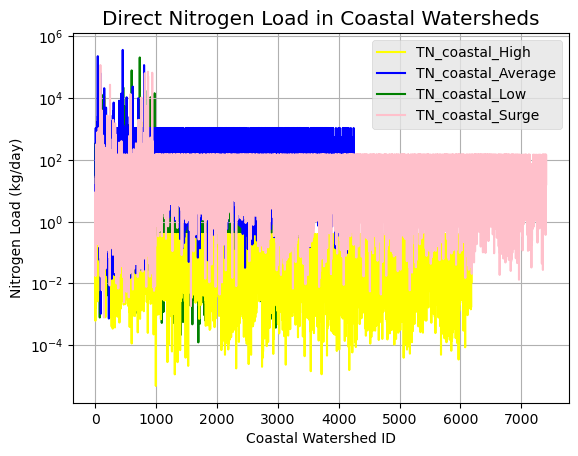

In [28]:

dfCoastalWatershed_high_merged[CoastalDirectTN_high_convert].plot(color='yellow', label='TN_coastal_High')
dfCoastalWatershed_avg_merged[CoastalDirectTN_avg_convert].plot(color='blue', label='TN_coastal_Average',zorder=2)
dfCoastalWatershed_low_merged[CoastalDirectTN_low_convert].plot(color='green', label='TN_coastal_Low', zorder=1)
dfCoastalWatershed_surge_merged[CoastalDirectTN_surge_convert].plot(color='pink', label='TN_coastal_Surge', zorder=3)
plt.xlabel('Coastal Watershed ID')
plt.ylabel('Nitrogen Load (kg/day)')
plt.yscale('log')
plt.style.use('ggplot')
plt.title('Direct Nitrogen Load in Coastal Watersheds')
plt.grid()
plt.legend()
filename = 'Nitrogen_Load_in_Coastal_Watersheds.png'
outputname = os.path.join(outFig, filename)
plt.savefig(outputname)

## boxplot

C:\Users\abolmaal\AppData\Local\Temp\ipykernel_31408\89952289.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


Text(0.5, 1.0, 'Direct Nitrogen Load in Coastal Watersheds')

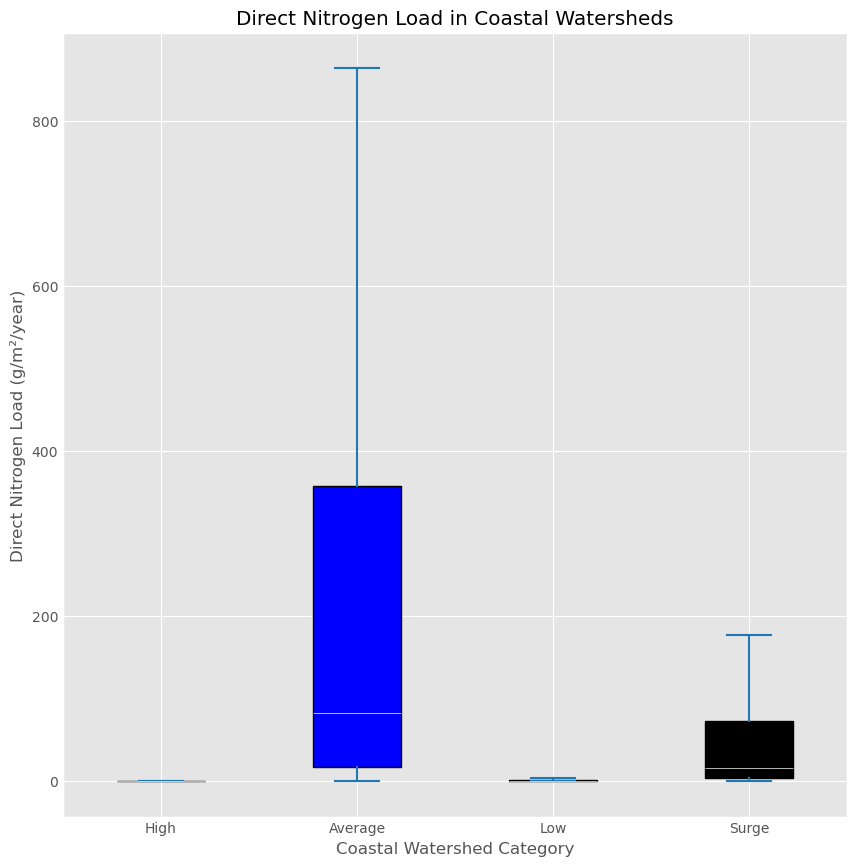

In [29]:
# Apply the '_mpl-gallery' style
plt.style.use('_mpl-gallery')

# Prepare the data using the updated field names
data_N = [
    dfCoastalWatershed_high_merged[CoastalDirectTN_high_convert],
    dfCoastalWatershed_avg_merged[CoastalDirectTN_avg_convert],
    dfCoastalWatershed_low_merged[CoastalDirectTN_low_convert],
    dfCoastalWatershed_surge_merged[CoastalDirectTN_surge_convert]
]

# Calculate the mean and standard deviation for each category (optional)
means = [d.mean() for d in data_N]
stds = [d.std() for d in data_N]

# Create the box plot
fig, ax = plt.subplots(figsize=(8, 8))
box = ax.boxplot(
    data_N,
    labels=['High', 'Average', 'Low', 'Surge'],
    patch_artist=True,
    showmeans=False,
    meanline=False,
    medianprops={"color": "white", "linewidth": 0.5},
    whiskerprops={"color": "C0", "linewidth": 1.5},
    capprops={"color": "C0", "linewidth": 1.5},
    meanprops={"color": "red", "linewidth": 1.5},
    showfliers=False
)

# Set different colors for each box
colors = ['red', 'blue', 'green', 'black']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Set labels and title
plt.xlabel('Coastal Watershed Category')
plt.ylabel('Direct Nitrogen Load (g/m²/year)')
plt.title('Direct Nitrogen Load in Coastal Watersheds')

In [ ]:
# Apply the '_mpl-gallery' style
plt.style.use('_mpl-gallery')

# Prepare the data (ensure these are numeric lists)
data_P = [
    dfCoastalWatershed_high[fieldCoastalTP_high],
    dfCoastalWatershed_avg[fieldCoastalTP_avg],
    dfCoastalWatershed_low[fieldCoastalTP_low],
    dfCoastalWatershed_surge[fieldCoastalTP_surge]
]

# Calculate the mean and standard deviation for each category
means = [np.mean(d) for d in data_P]
stds = [np.std(d) for d in data_P]

# Plot the box plot
fig, ax = plt.subplots(figsize=(8, 8))
box = ax.boxplot(data_P, labels=['High', 'Average', 'Low', 'Surge'], patch_artist=True, showmeans=True, meanline=True,
                 medianprops={"color": "white", "linewidth": 0.5},
                 whiskerprops={"color": "C0", "linewidth": 1.5},
                 capprops={"color": "C0", "linewidth": 1.5},
                 meanprops={"color": "red", "linewidth": 1.5},
                 showfliers=False)

# Set different colors for each box
colors = ['red', 'blue', 'green', 'black']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

# Set labels and title
plt.xlabel('Coastal Watershed Category')
plt.ylabel('Phosphorus Load (kgcellday)')
plt.title('Phosphorus Load in Coastal Watersheds')

filename = 'Phosphorus_Load_in_Coastal_Watersheds_boxplot.png'
output_path = os.path.join(outFig, filename)
plt.savefig(output_path, dpi= 300)
